In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from glob import glob
from scipy.signal import resample,savgol_filter
import math
from numpy.fft import * 

In [3]:
datadir = "/home/doshna/Documents/PHD/data/fatties/"
stims = glob(datadir+"*/*.csv")

In [2]:
spath = stims[2]
stim = pd.read_csv(spath)
start = np.array(stim["Time"])[-1] -60 ## last 60 seconds are what we want to sync with MP 

tst = stim[stim["Time"]>=start] ## The true stim df 


NameError: name 'stims' is not defined

In [5]:
fs_orig = math.floor(tst.shape[0]/60)
fs = 1000 
target_samples = int(np.floor(60 * fs)) 
ds_stim = resample(stim["Position"],target_samples)
ds_time = np.linspace(0,60.,target_samples)

In [2]:
def for_range(signal, fs,freq_range):
    N = len(signal)
    fr = fftfreq(N,1/fs)
    fft_sig = fft(signal)

    freq_indices = np.where((fr >= freq_range[0]) & (fr <= freq_range[1]))

    fft_range = np.abs(fft_sig[freq_indices])
    freq_range = fr[freq_indices]

    return(fft_range,freq_range)

In [7]:
f,t = for_range(ds_stim[0:20000],1000,[0,20])

In [3]:
freqs = np.array([0.2000,0.3000,0.5000,0.7000,1.100,1.300,1.700,1.900,2.300,2.900,3.700,4.300,5.300,6.100,7.900,8.900,11.30,13.70,16.70 ,19.90]
)

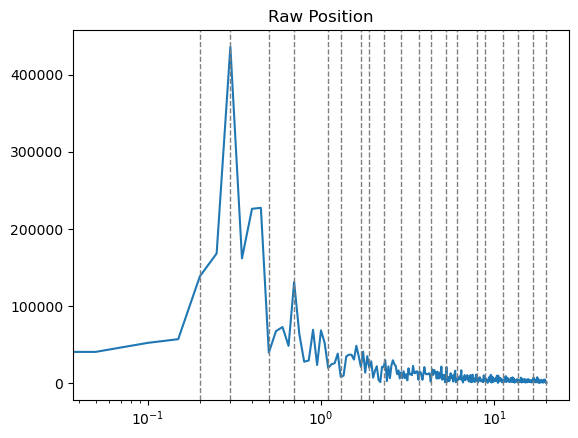

In [12]:
plt.semilogx(t,f)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("Raw Position")
plt.savefig("RawPos.png")

In [38]:
sg = savgol_filter(ds_stim,201,2)
sgv = savgol_filter(ds_stim,201,2,deriv=1)


In [39]:
sgm,sgf = for_range(sg[0:20000],1000,[0,20])
sgvm, sgvf = for_range(sgv[0:20000],1000,[0,20])

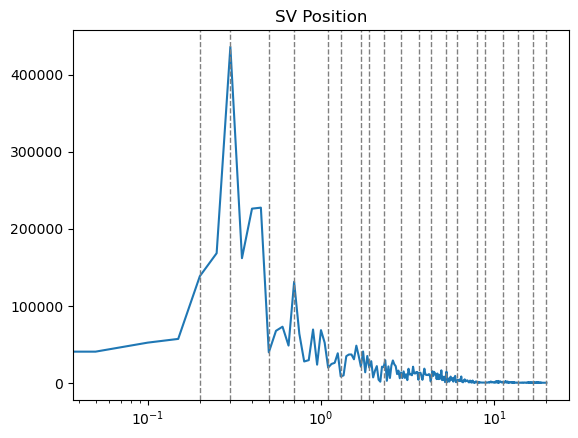

In [40]:
plt.semilogx(sgf,sgm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Position")
plt.savefig("SVpos.png")

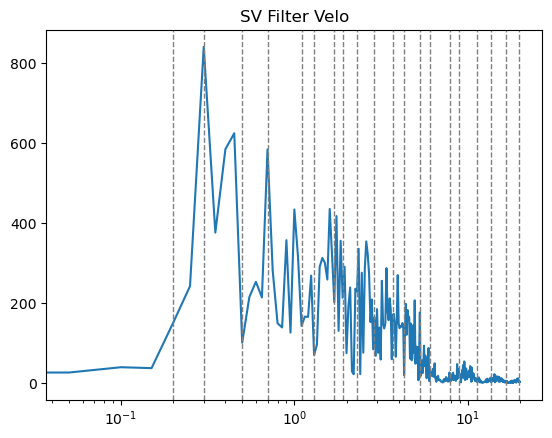

In [41]:
plt.semilogx(sgvf,sgvm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Filter Velo")
plt.savefig("SVVelo.png")

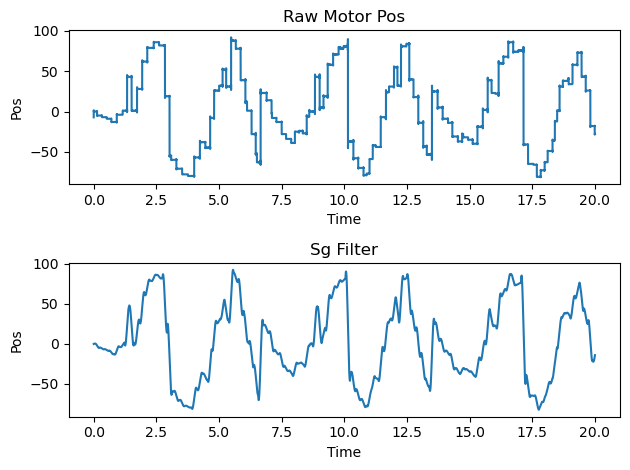

In [37]:
s = ds_stim[0:20000]
sgthis = savgol_filter(ds_stim[0:20000],201,2)

t = np.linspace(0,20,len(s))
plt.subplot(211)
plt.plot(t,s)
plt.xlabel("Time")
plt.ylabel("Pos")
plt.title("Raw Motor Pos")
plt.subplot(2,1,2)
plt.plot(t,sgthis)
plt.title("Sg Filter")
plt.xlabel("Time")
plt.ylabel("Pos")
plt.tight_layout()
plt.savefig("MotorPos/rawsigcomp.png")
plt.show()


Okay lets look at the DLT tracked flower position

In [4]:
d = pd.read_csv("DLTdv8_data_000_0xypts.csv")
x = d["pt1_cam1_X"]

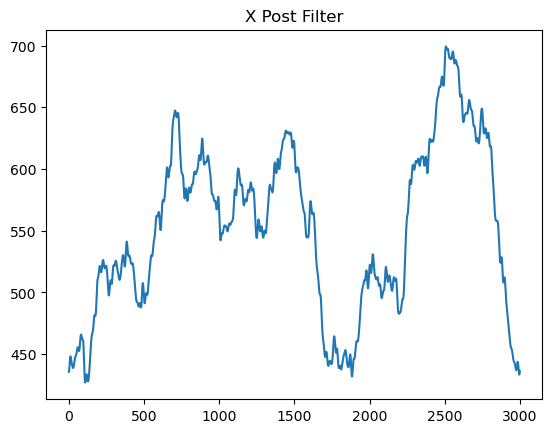

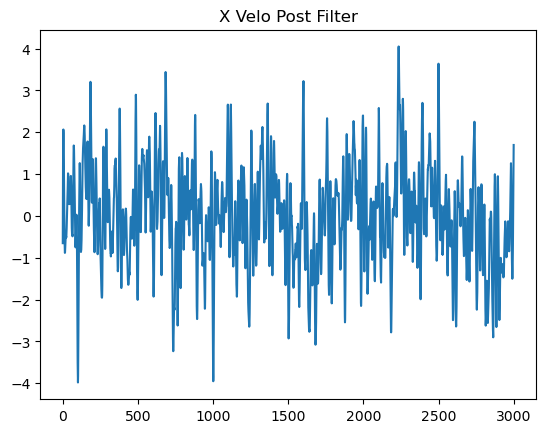

In [5]:
sgx = savgol_filter(x,21,5)
plt.plot(sgx)
plt.title("X Post Filter")
plt.show()
sgxv = savgol_filter(x,21,5,deriv=1)
plt.plot(sgxv)
plt.title("X Velo Post Filter")
plt.show()

In [6]:
sgxm,sgxf = for_range(sgx,300,[0,20])
sgxm = sgxm[1:] /np.max(sgxm[1:])
sgxf = sgxf[1:]

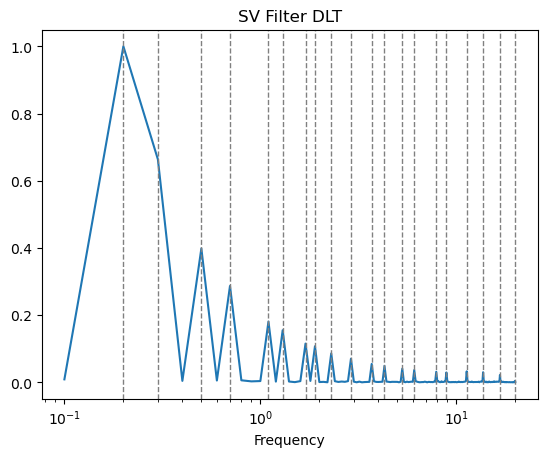

In [8]:
plt.semilogx(sgxf,sgxm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Filter DLT")
plt.xlabel("Frequency")
plt.savefig("SVDLT.png")
plt.show()

Lets Look at Veloctity

In [9]:
sgxvm,sgxvf = for_range(sgxv,300,[0,20])
sgxvm = sgxvm[1:] /np.max(sgxvm[1:])
sgxvf = sgxvf[1:]

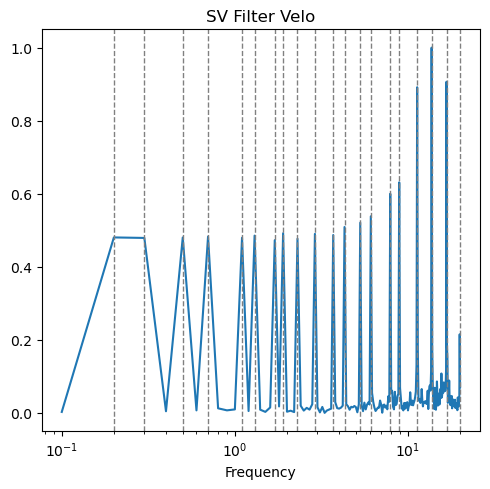

In [10]:
plt.figure(figsize=(5,5))
plt.semilogx(sgxvf,sgxvm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("SV Filter Velo")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("SVVeloDLT.png")
plt.show()

Lets make a big figure

In [15]:
t = np.linspace(0,10,3000)

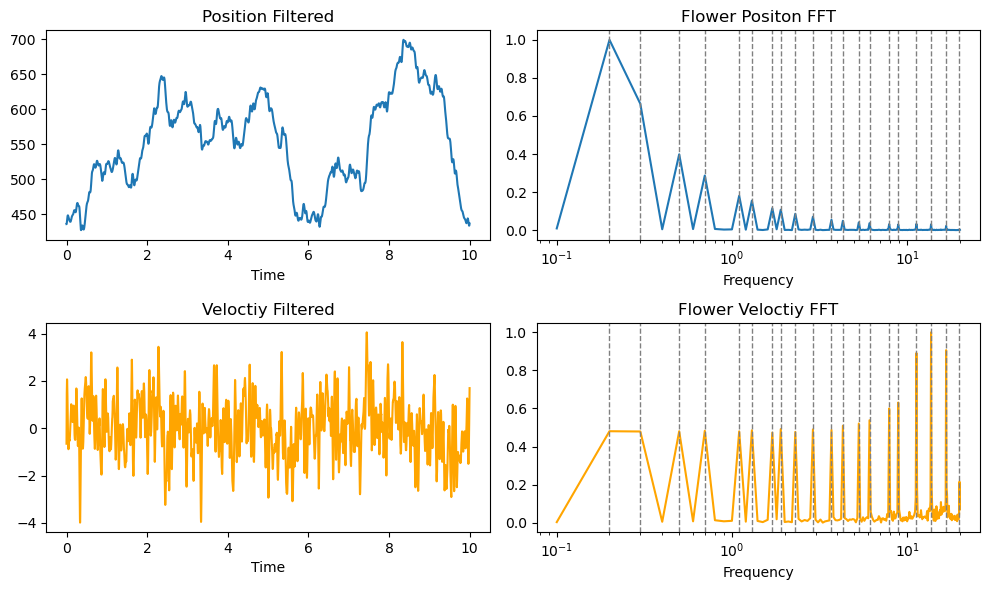

In [25]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(t,sgx)
plt.title("Position Filtered")
plt.xlabel("Time")
plt.subplot(223)
plt.plot(t,sgxv,color="orange")
plt.title("Veloctiy Filtered")
plt.xlabel("Time")

plt.subplot(222)
plt.semilogx(sgxf,sgxm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("Flower Positon FFT")
plt.xlabel("Frequency")

plt.subplot(224)
plt.semilogx(sgxvf,sgxvm,color="orange")
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)
plt.title("Flower Veloctiy FFT")
plt.xlabel("Frequency")

plt.tight_layout()
plt.savefig("posandveloandfft.png",bbox_inches="tight")
plt.show()
